In [1]:
import numpy as np
import torch

import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict
from gym.utils import seeding

import random

from agent import PPO
import os
import matplotlib.pyplot as plt

In [2]:
class Heater(Env):
    def __init__(self):

        self.done = False
        self.reward = 0
        self.max_time = 30

        # Action declaration
        self.action_space = Dict({
            "discrete": Discrete(3), # Discrete actions up, down, stay
            "continuous": Box(low=np.array([0., ]), high=np.array([1., ]), dtype=np.float32) 
        })

        # Temperature array
        self.low = np.array([0.,])
        self.high = np.array([100.,])
        self.observation_space = Box(low=self.low, high=self.high, dtype=np.float32)
        
        # Set start temp and start time
        self.reset()
    
    
    def seed(self,seed=None):
        self.np_random, seed = seeding.np_random(seed)

    def step(self, action):
        temp = self.state[0]

        d_action = action["discrete"]

        c_action = action["continuous"]
        c_action = self.interpolation(c_action)[0]
        
        if d_action == 0: # Increase temperature
            temp += c_action
        
        elif d_action == 1: # Decrease temperature
            temp -= c_action
        
        elif d_action == 2:
            temp += 0
        
        # Reward function

        if self.time > 0:
            self.reward -= abs(38.0 - temp) 
            
            if 37.5 <= temp <= 39.0:
                reward = 100
                self.done = True
            
            if abs(38.0 - temp) >= 20:
                reward = -100
                self.done = True

        # Reduce time by 1 second
        self.time -= 1 


        self.state = np.array([temp, ], dtype=np.float32)

        if self.time <= 0:
            self.done = True
            
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, self.reward, self.done, info
    
    def interpolation(self, x):
        # interpolation
        y1 = 0.
        y2 = 5.
        x1 = 0.
        x2 = 1.

        y = y1 + ((y2 - y1)/(x2 - x1))*(x-x1)
        return y

    def render(self):
        # Implement visualization --> in this case is not built
        pass
    
    def reset(self):
        # Reset shower temperature
        temp =  38. + random.randint(-5, 5)
        self.state = np.array([temp, ], dtype=np.float32)

        self.done = False
        self.reward = 0
        
        # Reset shower time
        self.time = self.max_time 
        return self.state


In [3]:
env = Heater()
episodes = 10

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    temps = []

    while not done:
        action = env.action_space.sample()  
        temp, reward, done, info = env.step(action)
        temps.append(temp) 
        score +=reward
    mean_temp = np.mean(np.array(temps))
    print(f'Episode: {episode}, Mean temperature: {mean_temp:.2f} Score: {score}')

Episode: 1, Mean temperature: 39.00 Score: -1.0
Episode: 2, Mean temperature: 49.78 Score: -4934.67822265625
Episode: 3, Mean temperature: 35.86 Score: -324.37434577941895
Episode: 4, Mean temperature: 40.02 Score: -14.40286636352539
Episode: 5, Mean temperature: 28.63 Score: -4187.115833282471
Episode: 6, Mean temperature: 38.30 Score: -0.2955169677734375
Episode: 7, Mean temperature: 38.00 Score: 0.0
Episode: 8, Mean temperature: 47.19 Score: -3701.1264724731445
Episode: 9, Mean temperature: 50.30 Score: -2141.873317718506
Episode: 10, Mean temperature: 29.57 Score: -4009.552885055542


c:\Users\Lenovo\anaconda3\envs\myenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Helper functions

In [4]:
def evaluate_policy(env, model, render, steps_per_epoch):
    scores = 0
    turns = 3
    for j in range(turns):
        s, done, ep_r, steps = env.reset(), False, 0, 0
        while not (done or (steps >= steps_per_epoch)):
            # Take deterministic actions at test time
            action_d, action_c = model.evaluate(s)
            action = {
                "discrete": action_d,
                "continuous": action_c 
            }
            s_prime, r, done, info = env.step(action)

            ep_r += r
            steps += 1
            s = s_prime
            if render:
                env.render()
        scores += ep_r
    return scores/turns


def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    
    plt.plot(x, running_avg, label="Running average")
    plt.plot(x, scores, alpha=0.4)
    plt.title('Learning plot')
    plt.xlabel("Runs")
    plt.ylabel("Scores")
    plt.legend(loc="best")

### Main training

c:\Users\Lenovo\Desktop\Python\Reinforcement Learning\5. PPO\Hybrid PPO\agent.py:113: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  state = T.tensor([state], dtype=T.float)


EnvName: Heater steps: 0k score: -385.6446253458659
EnvName: Heater steps: 5k score: -336.7767626444499
EnvName: Heater steps: 10k score: -98.12970860799153
EnvName: Heater steps: 15k score: -171.40432739257812
EnvName: Heater steps: 20k score: -229.84312947591147
EnvName: Heater steps: 25k score: -225.19059626261392
EnvName: Heater steps: 30k score: -118.6408182779948
EnvName: Heater steps: 35k score: -126.60556411743164
EnvName: Heater steps: 40k score: -154.89241409301758
EnvName: Heater steps: 45k score: -61.208744049072266
EnvName: Heater steps: 50k score: -146.2775993347168
EnvName: Heater steps: 55k score: -114.82867940266927
EnvName: Heater steps: 60k score: -58.73121770222982
EnvName: Heater steps: 65k score: -165.67941919962564
EnvName: Heater steps: 70k score: -74.69070180257161
EnvName: Heater steps: 75k score: -108.04667282104492
EnvName: Heater steps: 80k score: -150.94921239217123
EnvName: Heater steps: 85k score: -117.22033055623372
EnvName: Heater steps: 90k score: -14

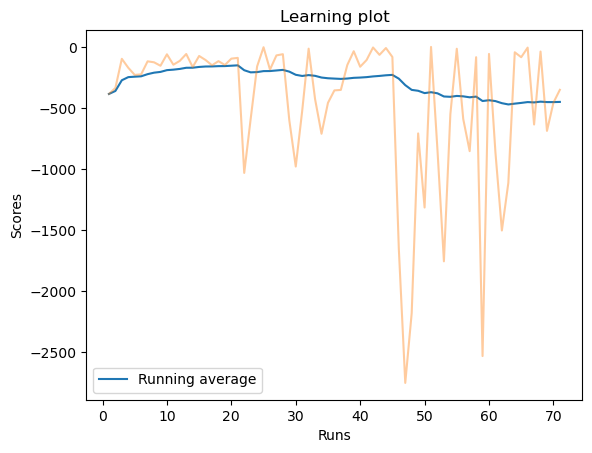

In [5]:
def main():

    random_seed = 0
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    env = Heater()
    env.seed(random_seed)
    
    # Evaluation environment
    eval_env = Heater()
    eval_env.seed(random_seed)

   

    # Hyperparameters
    kwargs = {
        "input_dims": env.observation_space.shape, 
        "actions": env.action_space, 
        "gamma": 0.99, 
        "gae_lambda": 0.95, 
        "policy_clip": 0.2, 
        "n_epochs": 10, 
        "net_width": 256, 
        "a_lr": 3e-4, 
        "c_lr": 3e-4, 
        "l2_reg": 1e-3, 
        "batch_size": 64, 
        "entropy_coef": 0, 
        "entropy_coef_decay": 0.9998
    }

    N = 2048 # lenth of long trajectory
    max_steps = env.max_time
    Max_train_steps = 350e3
    save_interval = 50e3
    eval_interval = 5e3
    best_interval = 100e3
    render = False


    if not os.path.exists('model'): 
        os.mkdir('model')
    
    if not os.path.exists('best_model'): 
        os.mkdir('best_model')
    
    model = PPO(**kwargs)

    
    traj_lenth = 0
    total_steps = 0
    score_history = []
    
    while total_steps < Max_train_steps:
        observation, done, steps, ep_r = env.reset(), False, 0, 0

        '''Interact & trian'''
        while not done:
            traj_lenth += 1
            steps += 1

            if render:
                env.render()
                action_d, action_c = model.evaluate(observation)
                action = {
                    "discrete": action_d,
                    "continuous": action_c 
                }
            else:
                action_d, probs_d, action_c, probs_c = model.select_action(observation)
                action = {
                    "discrete": action_d,
                    "continuous": action_c 
                }

            observation_, reward, done, info = env.step(action)
            model.remember(observation, observation_, action_d, action_c, probs_d, probs_c, reward, done)

            observation = observation_
            ep_r += reward

            '''update if its time'''
            if not render:
                if traj_lenth % N == 0:
                    model.train()
                    traj_lenth = 0
            
            '''record & log'''
            if total_steps % eval_interval == 0:
                score = evaluate_policy(eval_env, model, False, max_steps)
                score_history.append(score)
                print('EnvName: Heater','steps: {}k'.format(int(total_steps/1000)),'score:', score)

            # scheduler.step(score)
            
            total_steps += 1

            '''save model'''
            if total_steps % save_interval==0:
                model.save(total_steps)
            

            ''' best model '''
            if total_steps >= best_interval:
                if score_history[-1] > score_history[-2]:
                    model.best_save()


    env.close() 
    
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history)

if __name__ == '__main__':
    main()

### Model testing

In [8]:
# Hyperparameters
env = Heater()
# Hyperparameters
kwargs = {
    "input_dims": env.observation_space.shape, 
    "actions": env.action_space, 
    "gamma": 0.99, 
    "gae_lambda": 0.95, 
    "policy_clip": 0.2, 
    "n_epochs": 10, 
    "net_width": 256, 
    "a_lr": 3e-4, 
    "c_lr": 3e-4, 
    "l2_reg": 1e-3, 
    "batch_size": 64, 
    "entropy_coef": 0, 
    "entropy_coef_decay": 0.9998
}


model = PPO(**kwargs)

model.load_best()
scores = []


for i in range(20):
    obs = env.reset()
    actions = []
    score = 0
    while True:
        action_d, action_c = model.evaluate(obs)
        action = {
                    "discrete": action_d,
                    "continuous": action_c 
                }
        obs, reward, done, info = env.step(action)
        score += reward
        actions.append(action)

        if done:
            print(f"Done, points: {score}")
            break
    
    scores.append(score)

print(f"Mean score: {np.mean(scores)}")



c:\Users\Lenovo\anaconda3\envs\myenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Done, points: -1795.156452178955
Done, points: -2274.705883026123
Done, points: -2818.53377532959
Done, points: -2274.705883026123
Done, points: -2274.705883026123
Done, points: -1795.156452178955
Done, points: -0.28232574462890625
Done, points: -1795.156452178955
Done, points: -38.891048431396484
Done, points: -108.29349517822266
Done, points: -1383.0151824951172
Done, points: -2274.705883026123
Done, points: -2274.705883026123
Done, points: -108.29349517822266
Done, points: -1795.156452178955
Done, points: -1042.3615913391113
Done, points: -108.29349517822266
Done, points: -11.672344207763672
Done, points: -108.29349517822266
Done, points: -108.29349517822266
Mean score: -1219.5189483642578
